<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-t0zholin
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-t0zholin
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.03426b69f0443a7d55bb4a4e30eff6a6bd01f3bf6_-cp36-none-any.whl size=119874 sha256=f7fb211347cc05debc4b57066ffb147d192e8ee08f44039f7c8b2fcbbdbe3f16
  Stored in directory: /tmp/pip-ephem-wheel-cache-gx65gqfd/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/MA/df_MA_20drtn_features.csv')

In [6]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,22.361350,34.700695,35.784734,46.595153,-75.659787,-80.424490,-83.158574,-52.515058,24.970219,34.085198,39.816940,45.661755,-0.528795,0.758377,-2.419100,-7.086265,-7.299342,-0.268662,-0.072441,-0.058064,-0.101346,-0.279522,-0.279522,-0.279522,-0.279522,-62.541864,-72.411627,-83.982591,-116.064710,-9.287712,-42.208871,0.442397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256531,-0.021508,0.256535,-0.213168,0.454361,-0.011637,27.549999,2.949999,4.019999,-1.204975e+06,-1.204975e+06,-1.204975e+06,-1.204975e+06,0.091619,0.139246,0.113822,0.054810,0.081149,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,31.808244,37.398194,39.746008,48.248912,-55.856420,-70.518875,-74.636462,-48.412846,38.779151,42.116948,46.693791,48.298275,1.326380,0.020781,1.321050,-5.391194,-4.166666,-0.286970,-0.094399,-0.068512,-0.101912,-0.273883,-0.273883,-0.273883,-0.273883,21.618979,-50.718117,-66.809672,-97.783782,-12.367865,-36.654884,0.854951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276527,-0.016276,0.255734,-0.067661,0.455355,-0.013922,27.490000,-0.059999,0.949999,3.061590e+06,3.061590e+06,3.061590e+06,3.061590e+06,0.120176,0.188948,0.156169,0.067261,0.887166,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,31.089459,38.325067,41.706847,48.347238,-59.386761,-74.488993,-78.052080,-50.056991,54.922199,42.409493,46.900770,50.851690,-0.524647,0.261776,1.559179,-3.502140,-6.862512,-0.295875,-0.113180,-0.078396,-0.102587,-0.274401,-0.274401,-0.274401,-0.274401,105.729250,30.264684,-40.616717,-73.995607,-15.479909,-31.181780,0.261588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254840,-0.003576,0.237344,-0.039489,0.455482,-0.013365,29.379999,1.889999,3.099998,9.159557e+05,9.159557e+05,9.159557e+05,9.159557e+05,-0.015346,0.107551,0.095375,0.039872,-0.273674,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,46.638817,39.536845,41.579721,49.987767,-9.653683,-54.372917,-60.451623,-42.992038,49.775849,35.435123,40.608667,52.329550,2.266319,3.079105,1.750922,-0.020419,-4.982778,-0.283988,-0.124579,-0.085678,-0.103097,-0.237058,-0.237058,-0.237058,-0.237058,53.578842,53.806883,-38.849235,-70.948996,-17.318827,-23.331927,0.914243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279183,-0.018453,0.254248,-0.037531,0.401926,-0.052988,26.360001,-3.019999,0.840000,9.701635e+06,9.701635e+06,9.701635e+06,9.701635e+06,0.165511,0.206382,0.170881,0.116297,0.880397,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,61.869840,50.257210,48.613818,58.332401,-15.050191,-24.376651,-24.376651,-29.871416,60.395524,37.245960,41.409841,55.493281,4.115603,5.916576,6.753921,6.647837,-0.049021,-0.235488,-0.122398,-0.087296,-0.102997,-0.140803,-0.140803,-0.140803,-0.140803,166.666667,309.182413,120.294859,39.915845,-15.481825,-12.116764,0.729323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311479,0.049763,0.295431,0.038285,0.412842,-0.042358,27.219999,0.859999,2.619999,1.689954e+07,1.689954e+07,1.689954e+07,1.689954e+07,0.246734,0.200265,0.225079,0.124880,-0.382123,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
from_date='2010-01-01'
to_date='2020-01-01'

In [9]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [10]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,76.955987,75.753959,77.232857,65.534121,-48.666605,-17.579768,-13.088299,-8.081924,55.014426,68.783669,68.153997,61.720057,-0.295905,-0.736493,-0.350222,0.486582,6.111965,0.364240,0.339109,0.312920,0.275734,0.547447,0.547447,0.547447,0.547447,-117.203952,-55.004263,38.285355,71.986622,82.733421,89.891323,0.617108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065398,-0.093271,0.143836,-0.054562,0.204164,-0.044035,19.350000,-0.690001,-0.580000,-2.360978e+05,-2.360978e+05,-2.360978e+05,-2.360978e+05,-0.005978,0.160038,0.140886,0.136524,0.384615,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,53.806858,74.710464,72.304951,63.274442,-52.923087,-24.089635,-15.419095,-9.521172,42.420657,61.547179,66.922650,58.726298,-0.203062,-0.164075,-1.083762,0.078323,6.955724,0.340313,0.333616,0.312422,0.276605,0.515942,0.515942,0.515942,0.515942,-117.675917,-123.247092,14.079246,57.159670,80.126758,87.319116,0.818180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065893,-0.084269,0.137015,-0.049835,0.193030,-0.030184,19.160000,-0.190001,-0.850000,-3.443387e+05,-3.443387e+05,-3.443387e+05,-3.443387e+05,0.059111,0.133728,0.189011,0.109513,-0.164342,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,41.702004,64.528694,73.834353,59.380406,-63.715667,-36.499987,-23.712296,-14.143366,30.767273,53.266668,65.382392,55.239081,-0.653466,-1.148575,-1.585396,-0.676787,6.403755,0.309609,0.324278,0.309822,0.277150,0.472057,0.472057,0.472057,0.472057,-132.476821,-182.395694,-42.312274,35.175139,78.293099,84.571202,0.944805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073384,-0.065369,0.140577,-0.046006,0.186854,-0.034502,19.059999,-0.100000,-0.900000,-8.570888e+05,-8.570888e+05,-8.570888e+05,-8.570888e+05,0.240349,0.269222,0.224530,0.088998,0.045248,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,41.536925,71.416109,74.914683,56.929130,-62.593376,-35.857074,-29.477344,-13.894244,40.962729,60.873890,65.358773,58.140904,0.035451,-0.820053,-0.781307,-0.524827,4.544332,0.276289,0.312221,0.305497,0.277382,0.433013,0.433013,0.433013,0.433013,-67.568371,-118.223009,-55.142333,37.656837,75.211089,80.843249,0.708075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073490,-0.079407,0.129113,-0.060510,0.182413,-0.035411,18.129999,-0.930000,-3.550001,-5.454853e+05,-5.454853e+05,-5.454853e+05,-5.454853e+05,0.303131,0.299381,0.202824,0.113462,-0.234010,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,28.572625,56.650110,60.737349,56.419267,-82.733856,-82.733856,-55.388348,-25.463613,34.247765,52.896564,60.292634,58.767668,-1.645803,-2.253875,-2.741008,-2.200299,2.326720,0.232782,0.294921,0.298232,0.277087,0.364143,0.364143,0.364143,0.364143,-131.756247,-159.435429,-193.498288,5.885934,70.486267,75.451890,0.256684,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.108160,-0.044480,0.144651,-0.011988,0.187633,-0.022425,17.549999,-0.580000,-2.490002,-1.920154e+06,-1.920154e+06,-1.920154e+06,-1.920154e+06,0.222710,0.229041,0.164569,0.122350,0.293688,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [11]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,76.209597,62.867253,67.021998,71.577752,-15.420413,-10.393605,-10.237750,-5.658705,65.889274,63.656603,68.579366,73.009432,0.349547,0.868246,0.837587,2.813366,4.963964,0.232194,0.211400,0.175011,0.076483,4.398218,4.398218,4.398218,4.398218,112.209045,100.095862,122.336000,154.576085,54.909462,58.145818,0.470592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097752,-0.049060,0.129968,-0.004635,0.143031,-0.069631,12.51,0.010000,-0.120000,3.559633e+06,3.559633e+06,3.559633e+06,3.559633e+06,-0.002782,-0.004693,0.060411,0.096017,1.010091,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,69.069295,58.906375,66.228107,67.611897,-25.545169,-17.217852,-17.217852,-10.208532,62.357395,62.734655,67.700448,70.298353,-0.435415,0.858383,0.104390,2.840238,5.202244,0.233597,0.213858,0.178905,0.079482,4.345931,4.345931,4.345931,4.345931,65.600567,76.443884,95.055941,131.492637,55.702912,59.460174,0.062265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097207,0.009080,0.128115,-0.006412,0.143928,-0.060281,12.61,0.099999,0.469999,8.171833e+05,8.171833e+05,8.171833e+05,8.171833e+05,-0.074795,-0.057628,0.025290,0.062062,-0.295898,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,80.336350,78.440854,66.785011,67.535841,-6.734934,-5.716412,-3.944127,-2.386013,64.278291,63.903024,62.106049,67.924745,0.514699,1.167289,1.078880,2.919133,3.099067,0.231004,0.217897,0.188343,0.088420,4.400847,4.400847,4.400847,4.400847,148.399969,136.301806,104.121739,126.961909,54.522250,59.864937,0.764177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093286,-0.004475,0.112934,-0.018521,0.132926,-0.026021,13.43,0.780001,0.850000,1.833935e+06,1.833935e+06,1.833935e+06,1.833935e+06,-0.117022,-0.054517,-0.007469,0.048668,0.491820,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,63.670532,65.465855,58.406787,63.530476,-49.097845,-27.568709,-19.021457,-11.507095,53.713404,57.606700,57.778071,64.858749,-1.004186,0.080674,-0.284692,0.550510,1.878654,0.225182,0.217271,0.190350,0.091303,4.186488,4.186488,4.186488,4.186488,-41.181353,19.395994,56.273392,85.355076,52.181805,57.972542,0.422878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094072,-0.003680,0.120177,-0.009791,0.136144,-0.006886,14.82,1.389999,2.320000,-1.513084e+06,-1.513084e+06,-1.513084e+06,-1.513084e+06,-0.244109,-0.035633,-0.029191,0.052209,0.330461,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,58.281937,66.562471,59.128721,64.305538,-37.886582,-21.273523,-14.677996,-8.879504,41.438809,56.740327,58.288247,62.581493,0.292219,-0.203882,0.444043,0.548897,4.230808,0.216718,0.215323,0.191571,0.094082,4.040236,4.040236,4.040236,4.040236,-54.301490,2.929503,45.768454,74.843509,51.039078,56.710305,0.892406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094061,-0.003146,0.092130,-0.035985,0.135230,-0.008697,13.78,-1.040000,1.270000,-2.899329e+05,-2.899329e+05,-2.899329e+05,-2.899329e+05,-0.041676,0.029525,0.020342,0.059891,-0.087945,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [12]:
df.drop(['timestamp'], inplace=True, axis=1)

In [13]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [14]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,59.857626,59.828383,55.754664,47.386234,-0.629935,-7.477926,-7.477926,-19.739514,58.515072,62.191175,57.005898,50.141807,2.454656,4.671548,6.768538,1.375603,4.197507,-0.075435,-0.107884,-0.110839,-0.016889,-0.345438,-0.345438,-0.345438,-0.345438,151.603634,166.391010,122.462785,146.885098,-19.459328,-25.883630,0.978021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258290,0.042319,0.253089,-0.024662,0.305311,0.011205,19.540001,-1.400000,-8.089998,4.366291e+06,4.366291e+06,4.366291e+06,4.366291e+06,0.287664,0.142733,0.032496,0.026341,0.082966,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,62.385295,59.612511,63.048197,67.091019,-3.689785,-5.463473,-11.848848,-7.451376,60.802964,44.486353,59.204959,68.729317,0.737700,0.765529,3.830202,4.203054,4.874941,0.168041,0.185536,0.207296,0.230139,3.550237,3.550237,3.550237,3.550237,114.782102,113.592603,142.574387,165.041043,42.616046,46.728449,0.726854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197901,-0.017460,0.202452,0.011899,0.158720,-0.015432,14.950000,-1.360000,-3.110000,5.052807e+06,5.052807e+06,5.052807e+06,5.052807e+06,0.316911,0.163031,0.191178,0.220770,-0.023683,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,60.579118,65.751825,58.711371,54.532805,-1.291905,-1.064095,-0.677526,-10.677500,51.582217,67.968861,57.707997,61.239317,1.555203,8.265399,6.352730,3.805841,11.798463,0.166772,0.063801,0.059309,0.155836,0.409046,0.409046,0.409046,0.409046,123.787329,178.747497,199.193352,175.686280,14.570689,18.885183,0.952435,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.507438,0.096127,0.414828,0.056591,0.409420,0.047595,24.530001,-0.929998,-6.789999,8.980541e+06,8.980541e+06,8.980541e+06,8.980541e+06,0.204978,0.190000,0.225578,0.154341,-0.425475,2.296,-8.899999e-02,0.108,0.219994,-1.210007,1.0
765,62.800519,71.065560,69.711661,59.939057,-28.257521,-16.489803,-13.208189,-11.170983,56.002799,65.960715,66.756851,57.503528,1.108371,0.911882,0.096386,1.710112,9.381835,0.364930,0.281014,0.210971,0.113014,0.523491,0.523491,0.523491,0.523491,129.284088,153.995950,126.835831,108.996902,75.753946,73.312561,0.284071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196245,-0.033149,0.212354,-0.011535,0.218033,-0.005993,15.070000,-0.760000,-1.850000,8.953184e+05,8.953184e+05,8.953184e+05,8.953184e+05,0.132643,0.212001,0.098078,-0.060925,0.232714,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,44.163961,49.173482,39.214828,50.590592,-59.041279,-48.723116,-65.957498,-56.766774,39.066563,46.967800,34.199820,44.422821,0.229613,0.527066,-0.884837,-0.519232,-4.019047,-0.040118,-0.023389,-0.007422,0.024438,-0.104782,-0.104782,-0.104782,-0.104782,47.334719,-38.417748,-23.737039,-20.677853,-8.292434,-8.776677,0.510564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094711,-0.022414,0.138548,-0.070379,0.209232,-0.016152,16.350000,1.170000,2.330000,1.268875e+05,1.268875e+05,1.268875e+05,1.268875e+05,-0.183673,-0.015140,-0.103228,-0.010052,-0.084016,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [15]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [16]:
train_labels.head()

1856    1.0
2747    1.0
898     1.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [17]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [18]:
get_sample_weights(train_labels)

real class weights are [1.63879599 0.7195301 ] [0 1]
value_counts (array([0, 1]), array([ 598, 1362]))


1856    0.71953
2747    0.71953
898     0.71953
765     0.71953
1100    0.71953
         ...   
2051    0.71953
1301    0.71953
2192    0.71953
1640    0.71953
2882    0.71953
Name: labels, Length: 1960, dtype: float64

In [19]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.63879599 0.7195301 ] [0 1]
value_counts (array([0, 1]), array([ 598, 1362]))


In [20]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [21]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_40',
 'wr_10',
 'wr_20',
 'wr_40',
 'mfi_40',
 'roc_3',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'cci_15',
 'cci_25',
 'kst_20',
 'kst_40',
 'realised_vol_10',
 'realised_vol_change_5d_10',
 'vix_level',
 'cmf_40',
 'curve',
 'dollarix_5d_change')

In [32]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_15',
 'rsi_40',
 'mfi_10',
 'mfi_40',
 'roc_1',
 'roc_20',
 'trix_15',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_20',
 'ibr',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'vix_5d_change',
 'cmf_40',
 'curve')

In [33]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_15,rsi_40,mfi_10,mfi_40,roc_1,roc_20,trix_15,trix_40,macd10,macd15,macd20,macd40,kst_20,ibr,realised_vol_10,realised_vol_20,realised_vol_40,vix_5d_change,cmf_40,curve
445,1.331263,1.152150,0.000107,0.822401,-0.245442,0.676130,1.313523,1.740255,-0.132832,-0.132832,-0.132832,-0.132832,1.208824,0.311253,-1.241380,-0.788120,-0.331883,-0.194993,1.007171,2.013397
448,1.023978,0.134741,-0.808574,0.411430,-0.038650,0.403588,1.167415,1.756609,-0.211387,-0.211387,-0.211387,-0.211387,1.052861,0.605374,-1.177826,-0.920451,-0.556910,-1.176824,0.775609,2.093196
452,0.266100,0.962305,-0.987576,1.320950,0.994179,0.670612,0.803124,1.729129,-0.275685,-0.275685,-0.275685,-0.275685,0.748719,0.950163,-0.228509,-0.575610,-0.456605,-0.475989,1.721918,2.006838
469,-2.246940,-1.622724,-1.580247,-1.382225,-0.873951,-2.220374,-1.232140,1.168488,-0.955214,-0.955214,-0.955214,-0.955214,-1.331330,-1.426493,2.937078,2.004766,1.040681,1.490979,-2.299436,1.836308
470,-2.137882,-1.491070,-1.485720,-1.293869,0.902787,-1.971405,-1.515478,1.072989,-0.984987,-0.984987,-0.984987,-0.984987,-1.577946,1.045361,2.737597,2.055606,1.069870,1.252959,-1.973669,1.902990


In [34]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [35]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [36]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.54131776, 0.45868224],
       [0.48642457, 0.51357543],
       [0.5510371 , 0.4489629 ],
       [0.52595615, 0.47404385],
       [0.55894727, 0.44105276],
       [0.5083746 , 0.49162543],
       [0.54484606, 0.45515397],
       [0.5696069 , 0.4303931 ],
       [0.55420977, 0.44579017],
       [0.5610075 , 0.43899256]], dtype=float32)

In [37]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
62/79 [======================>.......] - ETA: 0s - loss: 0.7284 - accuracy: 0.5097
Epoch: 0, accuracy:0.5242,  loss:0.7297,  val_accuracy:0.6811,  val_loss:0.6609,  
79/79 [==============================] - 0s 5ms/step - loss: 0.7297 - accuracy: 0.5242 - val_loss: 0.6609 - val_accuracy: 0.6811
Epoch 2/200
79/79 [==============================] - 0s 4ms/step - loss: 0.7017 - accuracy: 0.5096 - val_loss: 0.6599 - val_accuracy: 0.6276
Epoch 3/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.5134 - val_loss: 0.6526 - val_accuracy: 0.6990
Epoch 4/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5714 - val_loss: 0.6491 - val_accuracy: 0.7066
Epoch 5/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5651 - val_loss: 0.6485 - val_accuracy: 0.6582
Epoch 6/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5829 - val_loss: 0.6524 - val_accur

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.366843,0.839923,0.453338,0.757653,195
196,0.375418,0.843112,0.466658,0.737245,196
197,0.392941,0.822704,0.458551,0.752551,197
198,0.385244,0.827168,0.434114,0.772959,198
199,0.408039,0.829719,0.454881,0.742347,199


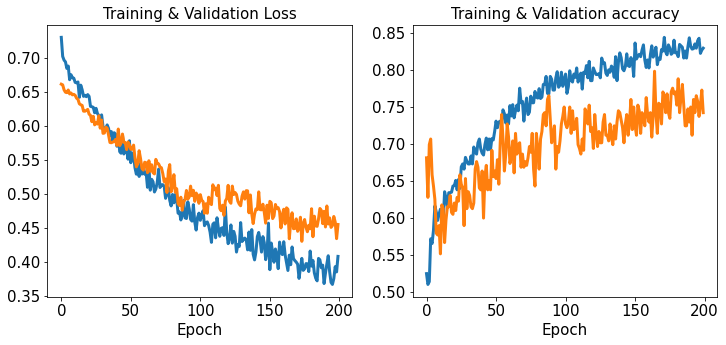

In [39]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [40]:
!pip install shap

     |████████████████████████████████| 276kB 8.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394132 sha256=2f5a212ae03ab84f17705e1535a04678f9ecb25b57e47ab7870f79512ba4fa05
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [41]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [42]:
shap_values  = explainer.shap_values(np.array(X_test_new))

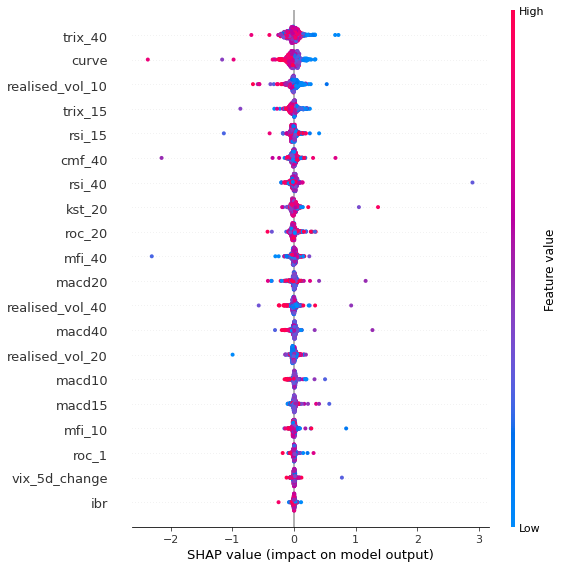

In [43]:
shap.summary_plot(shap_values[1], X_test_new)

In [45]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


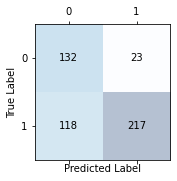

In [47]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.904
Recall: 0.648
F1: 0.755


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [50]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [52]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [10,20,30,40],
  }
]

In [53]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [55]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [56]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 27.6min finished


In [58]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/MA/xgb_MA_log_reg.pickle', "wb"))

In [59]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9133364626706919
Accuracy: 0.8530612244897959


Confusion Matrix


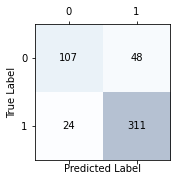

In [60]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [61]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7fee7926e0d0>}


In [62]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.1)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.212245	validation_0-logloss:0.657158	validation_1-error:0.271429	validation_1-logloss:0.666244
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.170408	validation_0-logloss:0.628014	validation_1-error:0.306122	validation_1-logloss:0.651816
[2]	validation_0-error:0.137755	validation_0-logloss:0.591646	validation_1-error:0.267347	validation_1-logloss:0.625063
[3]	validation_0-error:0.119388	validation_0-logloss:0.555645	validation_1-error:0.22449	validation_1-logloss:0.596936
[4]	validation_0-error:0.117347	validation_0-logloss:0.533851	validation_1-error:0.228571	validation_1-logloss:0.58667
[5]	validation_0-error:0.104592	validation_0-logloss:0.510295	validation_1-error:0.232653	validation_1-logloss:0.577089
[6]	validation_0-error:0.085714	validation_0-logloss:0.482337	validation_1-error:0.226531	validation_1-logloss:0.5588

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [67]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.73%


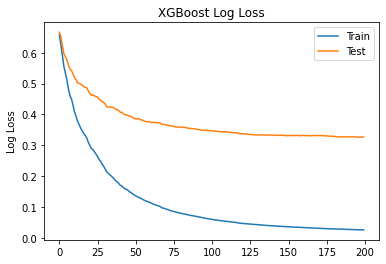

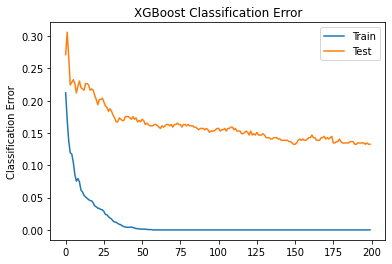

In [68]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [65]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


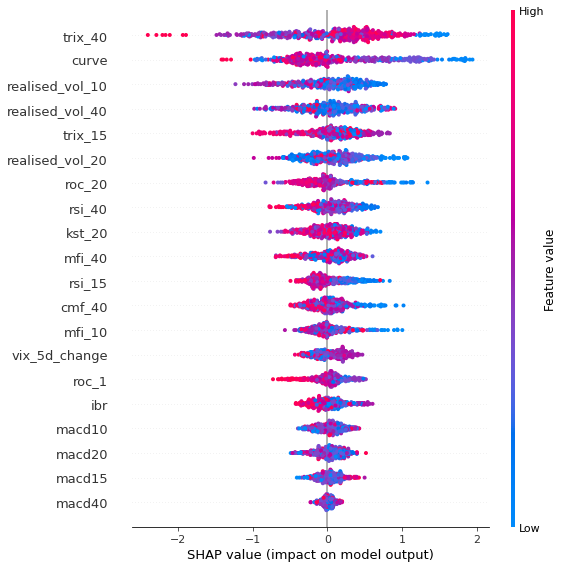

In [66]:
shap.summary_plot(shap_values, X_test_new)

In [69]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


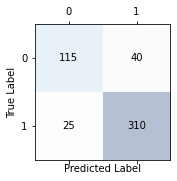

In [70]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()